# Generalized Linear Models

##### Keywords: glm, regression, poisson regression, link-function

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


When we do linear regression, we combine a Gaussian likelihood with a formula for the mean $\mu$ that is linear in the coeeficients of the features, or co-variates that go into the model. For an outcome variable $y$ far from any theoretical extremum, this is the maximum-enropy choice.

But the Gaussian likelihood is a poor choice for constraints such as the outcome being counts, or being only positive.

We can do better: lets use all the information we have about the constraints on an outcome variable to choose a likelihood, typically in the exponential family, that is a maxent distribution.

## Basic form of glms

Once this is done, all we need to do is to figure what parameter of this distribution can be modelled by linear regression. This constraint typically takes the form

$$f(p_i) = \alpha + \beta x_i$$

where $p_i $ is the parameter at the ith data point.

We have already seen an example of this in the bioassy, where $f$ is the logit, and the parameter $p_i$ is the probability in the ith experiment, so that we have

$$logit(p_i) = \alpha + \beta x_i,$$

And where the likelihood used is $Binom(n_i, p_i)$.

The logit function just gives the log odds $log(p_i/(1-p_i))$ and thus $p_i$ is squeezed through the inverse  logit function to make sure it goes from -1 to 1.

The logit function is an example of a **link** function.

Remember the binomial distribution is the least informative distribution we can use to model our prior knowledge of y. Different constraints, different maximum entropy distribution.

Link functions are needed as there is rarely a parameter like $\mu$ describing a average outcome, and also, rarely are these parameters unbounded. Its job is to map the linear space of the model (the $\alpha + \beta x_i$ part, nothing special about this, just a choice) to the non-linear space of parameters like $p$.

For most GLMs, the common links we use are the **logit** link, already used by you in the bioassay Binomial GLM to model the space of probabilities, and the **log** link which you will use here to enforce positiveness on a parameter in poisson regression.

### Interpretation of changes changes

The interpretation of what a unit change in a covariate means to the outcome changes. In Linear regression the coefficent meant (in the absence of interactions), hoding everything else the same, the outcome changes by "coefficient" amount.

For the logit link, each additional unit change in x produces smaller and smaller increases in probability, until any increase is very small.

The log-link uses $f=log$ such that

$$log(\lambda_i) =  \alpha + \beta x_i$$.

This ensures that $\lambda_i$ is positive! We could use this for a standard deviation, for example. It also implies an exponential scaling of the outcome with $x$...an increase of one unit on log scale means one order of magnitude on the $\lambda$ scale.

Thus, in a sense GLMs force self-interaction in covariates, sice the rate of change with a covariate is not linear any more but involves itself and potentialy other covariates.

## Monks copying Manuscripts.

This is a model taken from McElreath's book.

>For example, suppose you own a monastery that is in the business, like many monasteries before the invention of the printing press, of copying manuscripts. You employ 1000 monks, and on any particular day about 1 of them finishes a manuscript. Since the monks are working independently of one another, and manuscripts vary in length, some days produce 3 or more manuscripts, and many days produce none. Since this is a binomial process, you can calculate the variance across days as np(1 − p) = 1000(0.001)(1 − 0.001) ≈ 1. You can simulate this, for example over 10,000 (1e5) days (McElreath 311-312)




In [2]:
from scipy.stats import binom

In [6]:
p=1/1000
rvs=binom.rvs(n=1000, p=1/1000, size=10000)

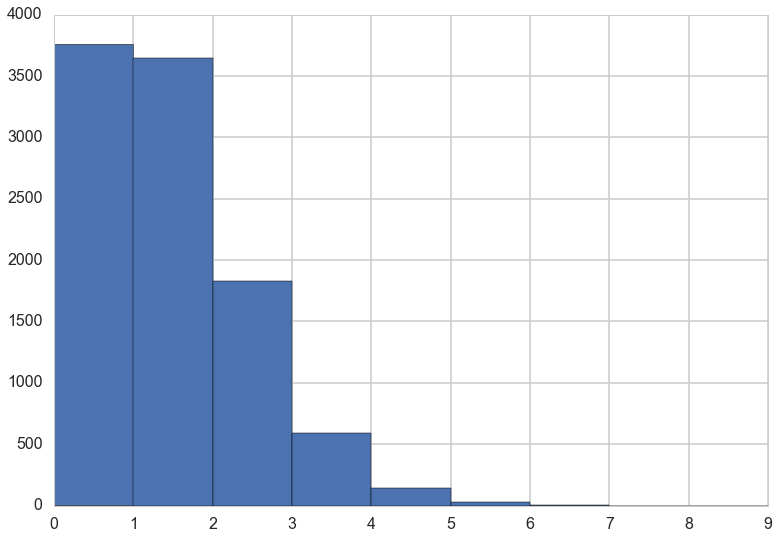

In [10]:
plt.hist(rvs, bins=np.arange(10));

## Modeling and generating using a Poisson GLM.

$$
y_i \sim Poisson(\lambda_i)\\
log(\lambda_i) = \alpha + \beta x_i
$$

>The parameter λ is the expected value, but it's also commonly thought of as a rate. Both interpretations are correct, and realizing this allows us to make Poisson models for which the exposure varies across cases i. Suppose for example that a neighboring monastery performs weekly totals of completed manuscripts while your monastery does daily totals. If you come into possession of both sets of records, how could you analyze both in the same model, given that the counts are aggregated over different amounts of time, different exposures?

Since we can interpret $\lambda$ as a rate, we can let it be $\mu$ events in time $\tau$, such that $\lambda = \mu/\tau$. Then

$$
y_i \sim Poisson(\lambda_i)\\
log(\lambda_i) = log(\frac{\mu_i}{\tau_i}) = \alpha + \beta x_i
$$

When $\tau_i = 1$, $log(\tau_i) = 0$ and $\mu$ and $\lambda$ are the same. But when the **exposure**, or the event time varies across cases, then $\tau_i$ scales the expected number of events for each  i. 
Thus we can write:

$$
y_i \sim Poisson(\mu_i)\\
log(\mu_i) = log(\tau_i) + \alpha + \beta x_i
$$

Simulating:

In [1]:
from scipy.stats import poisson
num_days=30
y=poisson.rvs(mu=1.5, size=30)

In [2]:
y

array([1, 0, 3, 3, 2, 0, 2, 1, 1, 3, 1, 3, 1, 0, 2, 4, 2, 0, 2, 0, 0, 2, 1,
       2, 0, 2, 1, 0, 3, 1])

>Also suppose that your monastery is turning a tidy profit, so you are considering purchasing another monastery. Before purchasing, you'd like to know how productive the new monastery might be. Unfortunately, the current owners don't keep daily records, so a head-to-head comparison of the daily totals isn't possible. Instead, the owners keep weekly totals. Suppose the daily rate at the new monastery is actually λ = 0.5 manuscript per day. To simulate data on a weekly basis, we just multiply this average by 7, the exposure: (McElreath 321)

In [3]:
num_weeks=4
y_new = poisson.rvs(mu=0.5*7, size=num_weeks)#per week
y_new

array([7, 5, 4, 2])

### Fitting the model

Lets massage the data in a form useful for carrying out our poisson regression:

In [25]:
yall=list(y) + list(y_new)
exposure=len(y)*[1]+len(y_new)*[7]
monastery = len(y)*[0]+len(y_new)*[1]
df=pd.DataFrame.from_dict(dict(y=yall, days=exposure, monastery=monastery))
df

,days,monastery,y
0,1,0,0
1,1,0,1
2,1,0,1
3,1,0,2
4,1,0,0
5,1,0,1
6,1,0,2
7,1,0,1
8,1,0,1
9,1,0,0


Now we set up the model in pymc, including two deterministics to capture the rates

In [38]:
import theano.tensor as t
with pm.Model() as model1:
    alpha=pm.Normal("alpha", 0,100)
    beta=pm.Normal("beta", 0,1)
    logmu = t.log(df.days)+alpha+beta*df.monastery
    y = pm.Poisson("obsv", mu=t.exp(logmu), observed=df.y)
    lambda0 = pm.Deterministic("lambda0", t.exp(alpha))
    lambda1 = pm.Deterministic("lambda1", t.exp(alpha + beta))

In [39]:
with model1:
    trace1 = pm.sample(5000)

100%|██████████| 5000/5000 [00:04<00:00, 1223.88it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1220b5c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12174ac88>]], dtype=object)

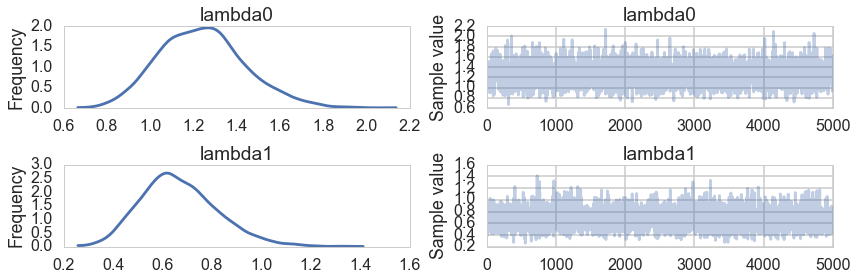

In [40]:
pm.traceplot(trace1, varnames=['lambda0', 'lambda1'])

In [41]:
pm.summary(trace1, varnames=['lambda0', 'lambda1'])


lambda0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.243            0.199            0.004            [0.869, 1.635]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.889          1.100          1.234          1.365          1.671


lambda1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.669            0.155            0.003            [0.394, 0.988]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.407          0.561          0.655          0.765          1.008



We get back the one-monstery is roughly twice as efficient than the other from here!